# Description
This script can be used for an optimization with an cylinder as an initial geometry. The diameter from the cylinder is fixed.

In [8]:
# Imports and physical parameters
import numpy as np
import scipy

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from ipywidgets import *
from matplotlib.widgets import Slider

# ddg imports
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from ddgclib._catenoid import *
from ddgclib._truncated_cone import *
from ddgclib._plotting import *

from timeit import default_timer as timer


def curvature(v):
    F, nn = vectorise_vnn(v)
    #curvature_dict = b_curvatures_hn_ij_c_ij(F, nn)
    curvature_dict = b_curvatures_hn_ij_c_ij_play(F, nn)
    HNdA_i = curvature_dict['HNdA_i']
    return HNdA_i





In [9]:
'''
in this part of the code, the boundarys will be closed with the function close_boundary.

'''
def close_boundary(HC, boundary_top, boundary_bottom):
    v_avg_top = np.zeros(3)
    for v in boundary_top:
        v_avg_top += v.x_a

    v_avg_top = v_avg_top/len(boundary_top)
    v_avg_bottom = np.zeros(3)
    for v in boundary_bottom:
        v_avg_bottom += v.x_a

    v_avg_bottom = v_avg_bottom/len(boundary_bottom)

    vat = HC.V[tuple(v_avg_top)]
    for v in boundary_top:
        v.connect(vat)

    vab = HC.V[tuple(v_avg_bottom)]
    for v in boundary_bottom:
        v.connect(vab)

#    boundary_top.add(vat) # from stefan
#    boundary_bottom.add(vab) # from stefan

    boundary_top.append(vat)
    boundary_bottom.append(vab)
    return HC, boundary_top, boundary_bottom

In [10]:
'''
Function for calculating the volume of the mesh
'''
def volume(v):
    F, nn = vectorise_vnn(v)
    curvature_dict = b_curvatures_hn_ij_c_ij_play(F, nn)
    #print(curvature_dict)
    V_ijk = curvature_dict['V_ijk']
    N_i = curvature_dict['N_i']
    #print(N_i)
    return V_ijk


'''
V = 0
for v in HC.V:
    V_ijk = volume(v)
    #print(V_ijk)
    V += np.sum(V_ijk)

V = V/12
'''

'\nV = 0\nfor v in HC.V:\n    V_ijk = volume(v)\n    #print(V_ijk)\n    V += np.sum(V_ijk)\n\nV = V/12\n'

# Functions

In [11]:
def fun_liquid_bridge(d_l, d_u, length, refinement, tau, t_f, gamma, V_final, damping_factor, volume_constraint):
    '''
    length = length of the inital cone
    tau = size of time step
    t_f = breaking condition in the while-loop = last time step
    d = diameter of the initial cyliner
    '''

    r_l = d_l / 2
    r_u = d_u / 2

    t = 0  #  initial time (=constant)

    v_l = 0
    v_u = length +v_l
    '''
    -----------------------------------------------------------
    From here, the mesh for an open truncated cone is meshed
    '''

    HC, bV, K_f, H_f, neck_verts, neck_sols = truncated_cone_initial_N(r_l, r_u, length, refinement)

    '''
    -----------------------------------------------------------
    closing the open mesh
    '''

    # Define bottom boundary condition
    boundary_bottom = []
    for v in HC.V:
        if v.x[2] == v_l:
            boundary_bottom.append(v)

    # Define top boundary condition
    boundary_top = []
    for v in HC.V:
        if v.x[2] == v_u:
            boundary_top.append(v)

    HC, boundary_top, boundary_bottom = close_boundary(HC, boundary_top, boundary_bottom)
    '''
    ----------------------------------------------------
    Dummy parameter for the residual
    '''
    # runvariable for the iteration tracking
    residual_iteration = 0
    iteration_list = []

    # list to track the progress from df
    df_list_max = []
    df_list_min = []

    # list to track the progress of HNdA
    dHNdA_list_min = []
    dHNdA_list_max = []

    res_list = []

    df_dv_list_max = []
    df_dv_list_min = []



    '''
    -----------------------------------------------------------
    From here, the optimization is started
    '''

    i = 0


    while t < t_f:
        # Loop through all interior vertices
        # calculating the volume of the entire bridge
        '''
        New Part Starting 1  ------------------------
        '''
        V_current = 0

        for v in HC.V:
            V_ijk = volume(v)
            #print(V_ijk)
            V_current += np.sum(V_ijk)

        V_current = V_current/12


        dv_const = (V_final - V_current)/ V_final
        print(V_current)
        '''
        New Part Ending 1 ------------------
        '''



        cHCV = copy.copy(HC.V)

        # dummy list to find the maximum df
        df_list_dummy       = []
        df_dv_list_dummy    = []
        dHNdA_list_dummy    = []
        for v in cHCV:
            # exclude boundaries
            if v in set(boundary_bottom):
                continue
            # Define top boundary condition
            if v in set(boundary_top):
                continue
            # Compute curvature for each interior vertex
            HNdA_i = curvature(v)
            # HNdA_i, V_i, N_i = ????(v)


            # split loop, compute V_total
            # start new    for v in cHCV:
            #
            #print(HNdA_i)
            # Step in time
            df = -gamma * HNdA_i  # Add compressive force F_c = N_i * (V_initial - V_total)
            dv = dv_const * HNdA_i
            df_dv = - df - dv
            #


           # v_new = v.x_a - tau/2 * df

            '''
            New Part Starting 2 ------------------
            '''
            if volume_constraint:
               v_new = v.x_a - tau/2 * df - tau/2 * dv  * damping_factor
            v_new = v.x_a - tau/2 * df - tau/2 * dv
               # v_new = v.x_a - tau/2 * df - tau/2 * dv * damping_factor

            if not volume_constraint:
                v_new = v.x_a - tau/2 * df
            '''
            New Part Ending 2 ------------------
            '''

            #
            HC.V.move(v, tuple(v_new))




            '''
            Try to implement a Residual with the mean curvature
            '''
            #print(HNdA_i)
            #print(np.linalg.norm(df))
            df_dv_list_dummy.append(np.linalg.norm(df_dv))
            df_list_dummy.append(np.linalg.norm(df))
            dHNdA_list_dummy.append(np.linalg.norm(HNdA_i))
            #print(df)
        #print(HNdA_i)
        #print(max(df_list_dummy))
        # if V_ne
        # save the maximum and minimum datas for the Residuals
        df_list_max.append(max(df_dv_list_dummy))
        df_list_min.append(min(df_dv_list_dummy))

        df_dv_list_max.append(max(df_list_dummy))
        df_dv_list_min.append(min(df_list_dummy))

        # save the numbers of iteration for lately plotting
        residual_iteration = residual_iteration +1
        iteration_list.append(residual_iteration)

        dHNdA_list_max.append(max(dHNdA_list_dummy))
        dHNdA_list_min.append(min(dHNdA_list_dummy))

        '''
        if i == 0:
            continue
        else:
            res = abs((df_list_max[i-1]-df_list_max[i])/df_list_max[i])

        '''



        res = abs((df_list_max[i-1]-df_list_max[i])/df_list_max[i])
        res_list.append(res)


        t += tau
        i += 1
        print(i)


    return(HC, iteration_list, df_list_min, df_list_max,res_list,i, df, dv, v_new, df_dv_list_max, df_dv_list_min)



In [22]:
def fun_liquid_bridge_test(d_l, d_u, length, refinement, tau, gamma, breaking_condition,itermax):
    '''
    length = length of the inital cone
    tau = size of time step
    t_f = breaking condition in the while-loop = last time step
    d = diameter of the initial cyliner
    '''
    starttime = timer()
    print('Simulation is started!')
    print('-------------------------------------')

    r_l = d_l / 2
    r_u = d_u / 2

    t = 0  #  initial time (=constant)

    v_l = 0
    v_u = length +v_l
    '''
    -----------------------------------------------------------
    From here, the mesh for an open truncated cone is meshed
    '''

    HC, bV, K_f, H_f, neck_verts, neck_sols = truncated_cone_initial_N(r_l, r_u, length, refinement)

    '''
    -----------------------------------------------------------
    closing the open mesh
    '''

    # Define bottom boundary condition
    boundary_bottom = []
    for v in HC.V:
        if v.x[2] == v_l:
            boundary_bottom.append(v)

    # Define top boundary condition
    boundary_top = []
    for v in HC.V:
        if v.x[2] == v_u:
            boundary_top.append(v)

    HC, boundary_top, boundary_bottom = close_boundary(HC, boundary_top, boundary_bottom)
    '''
    ----------------------------------------------------
    Dummy parameter for the residual
    '''
    # runvariable for the iteration tracking
    residual_iteration = 0
    iteration_list = []

    # list to track the progress from df
    df_list_max = []
    df_list_min = []

    # list to track the progress of HNdA
    dHNdA_list_min = []
    dHNdA_list_max = []

    res_list = []

    volume_list = []



    '''
    -----------------------------------------------------------
    From here, the optimization is started
    '''

    iters = 0


    while True:
        # Loop through all interior vertices
        # calculating the volume of the entire bridge
        '''
        New Part Starting 1  ------------------------
        '''
        V_current = 0

        for v in HC.V:
            V_ijk = volume(v)
            #print(V_ijk)
            V_current += np.sum(V_ijk)

        V_current = V_current/12

        volume_list.append(V_current)



        '''
        New Part Ending 1 ------------------
        '''


        cHCV = copy.copy(HC.V)

        # dummy list to find the maximum df
        df_list_dummy       = []

        dHNdA_list_dummy    = []
        for v in cHCV:
            # exclude boundaries
            if v in set(boundary_bottom):
                continue
            # Define top boundary condition
            if v in set(boundary_top):
                continue
            # Compute curvature for each interior vertex
            HNdA_i = curvature(v)
            # HNdA_i, V_i, N_i = ????(v)


            # split loop, compute V_total
            # start new    for v in cHCV:
            #
            #print(HNdA_i)
            # Step in time
            df = -gamma * HNdA_i  # Add compressive force F_c = N_i * (V_initial - V_total)

            v_new = v.x_a - tau/2 * df

            #
            HC.V.move(v, tuple(v_new))



            '''
            Try to implement a Residual with the mean curvature
            '''
            #print(HNdA_i)
            #print(np.linalg.norm(df))

            df_list_dummy.append(np.linalg.norm(df))
            dHNdA_list_dummy.append(np.linalg.norm(HNdA_i))
            #print(df)
        #print(HNdA_i)
        #print(max(df_list_dummy))
        # if V_ne

        iters += 1
        # save the maximum and minimum datas for the Residuals
        df_list_max.append(max(df_list_dummy))
        df_list_min.append(min(df_list_dummy))

        # save the numbers of iteration for lately plotting
        iteration_list.append(iters)

        dHNdA_list_max.append(max(dHNdA_list_dummy))
        dHNdA_list_min.append(min(dHNdA_list_dummy))


        if iters%100 == 0:
            # print(f"Time elapsed: {complex[6]-complex[5]:.2f} s")
            interimstime = timer()
            print(f"Iteration elapsed: {iters:.0f}")
            print(f"Time elapsed:{interimstime-starttime:.2f} s")
            print(f"Amount of highest displacement: {max(df_list_dummy)*10**6:.2f} mikrometer")

        if iters > itermax:
            endtime = timer()
            print('-------------------------------------')
            print("Too many iterations! Simulation is canceled!")
            print(f"Time elapsed for canceled Simulation: {endtime-starttime:.2f} s")
            break

        if max(df_list_dummy) < breaking_condition:
            endtime = timer()
            print('-------------------------------------')
            print("Simulation is finished and is terminated without a problem.")
            print(f"Time elapsed for hole Simulation: {endtime-starttime:.2f} s")
            break


    return(HC, iteration_list, df_list_min, df_list_max, volume_list)



# Using the Function

In [23]:
#gamma = 728e-6  # N/m, surface tension of water at 20 deg C
gamma = 0.078  # N/m, surface tension of water at 20 deg C
refinement= 3 # NOTE: 2 is the minimum refinement needed for the complex to be manifold
d_l = 0.8e-3 # radian on the lower side of the cone
d_u = 1.6e-3 # diameter on the upper side of the cone
length = 0.7e-3 # length of the cone
length = 0.4e-3 # length of the cone
tau = 0.1    # Endtime for calculation
'''
t_f = 100 # final time of the time step
V_final = 0.084
damping_factor = 1
'''


breaking_condition = 1e-9
itermax = 18e3

#dummy_parameter = fun_liquid_bridge(-0.5, 0.5,0, 0,1) # v_l, v_u, tau, tf, d
# def fun_liquid_bridge(d_l, d_u, length, refinement, tau, t_f, gamma, V_final, damping_factor, volume_constraint)

# def fun_liquid_bridge_test(d_l, d_u, length, refinement, tau, gamma, breaking_condition,itermax):
dummy_parameter2 = fun_liquid_bridge_test(d_l, d_u, length, refinement, tau, gamma, breaking_condition,itermax)

# dummy_parameter = fun_liquid_bridge(d_l, d_u, length, refinement, tau, t_f, gamma, V_final, damping_factor, True)







Simulation is started!
-------------------------------------
Iteration elapsed: 100
Time elapsed:27.06 s
Amount of highest displacement: 2.34 mikrometer
Iteration elapsed: 200
Time elapsed:53.70 s
Amount of highest displacement: 1.87 mikrometer
Iteration elapsed: 300
Time elapsed:80.17 s
Amount of highest displacement: 1.59 mikrometer
Iteration elapsed: 400
Time elapsed:106.62 s
Amount of highest displacement: 1.32 mikrometer
Iteration elapsed: 500
Time elapsed:133.37 s
Amount of highest displacement: 1.10 mikrometer
Iteration elapsed: 600
Time elapsed:160.13 s
Amount of highest displacement: 0.93 mikrometer
Iteration elapsed: 700
Time elapsed:187.44 s
Amount of highest displacement: 0.78 mikrometer
Iteration elapsed: 800
Time elapsed:215.43 s
Amount of highest displacement: 0.66 mikrometer
Iteration elapsed: 900
Time elapsed:243.52 s
Amount of highest displacement: 0.56 mikrometer
Iteration elapsed: 1000
Time elapsed:270.60 s
Amount of highest displacement: 0.47 mikrometer
Iteration e

In [24]:
HC = dummy_parameter2[0]
iteration_list = dummy_parameter2[1]
df_list_min = dummy_parameter2[2]
df_list_max = dummy_parameter2[3]
volume_list = dummy_parameter2[4]

In [25]:
plot_polyscope(HC)

np.zeros([self.V.size(), self.dim]) = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]

In [26]:
df_list_max

[4.301616713358493e-05,
 4.2532615389027834e-05,
 4.1992690931179594e-05,
 4.138936329343988e-05,
 4.071529890340926e-05,
 3.9963227199176644e-05,
 3.9126482814281764e-05,
 3.819970899739584e-05,
 3.717963824840658e-05,
 3.606578806528575e-05,
 3.486087629480491e-05,
 3.357082898175221e-05,
 3.220441487404984e-05,
 3.077268890777606e-05,
 2.928844680946511e-05,
 2.776578383323376e-05,
 2.6219720690156794e-05,
 2.4665804657713943e-05,
 2.3119623382017925e-05,
 2.159623555452946e-05,
 2.010957853276086e-05,
 1.867193560727297e-05,
 1.7293535505824216e-05,
 1.5982326314908722e-05,
 1.4743930194358113e-05,
 1.3581755596624463e-05,
 1.2497225971051186e-05,
 1.1490078566916031e-05,
 1.0558690976005367e-05,
 9.700402334685326e-06,
 8.911806950415092e-06,
 8.18900804525459e-06,
 7.527827091645966e-06,
 6.923969571925799e-06,
 6.373151193332187e-06,
 5.871190134625065e-06,
 5.4140713112357676e-06,
 4.997988365158897e-06,
 4.619368442428859e-06,
 4.478150206453584e-06,
 4.3944252120757385e-06,
 

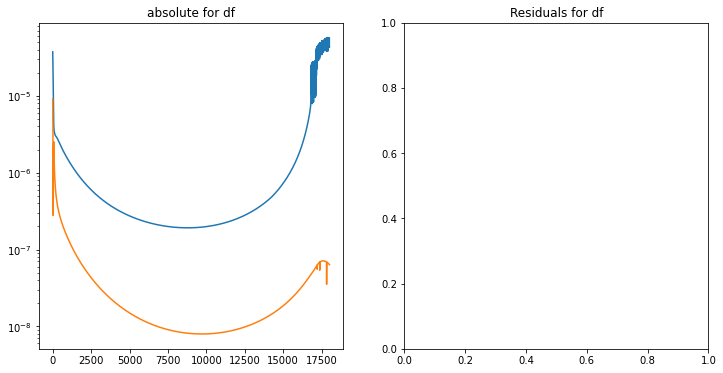

In [21]:
'''
Plot of the residual data
'''
fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(12, 6))


ax[0].plot(iteration_list, df_list_max)
ax[0].plot(iteration_list, df_list_min)
ax[0].set_yscale('log')

#ax[1].plot(iteration_list, res_list)
#ax[1].plot(iteration_list, dHNdA_list_min)



ax[0].set_title('absolute for df')
ax[1].set_title('Residuals for df')

fig.savefig('Residuals_with_volume.png')

In [46]:
plot_polyscope(HC)

np.zeros([self.V.size(), self.dim]) = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]

In [41]:
def save_complex_dummy(HC,filename):
    for v in HC.V:
        print('---')
        v_new = []
        for i, vi in enumerate(v.x):
            print(type(vi))
            v_new.append(float(vi))
            #v.x[i] = float(vi)
        HC.V.move(v, tuple(v_new))
        v.x_a = np.array(v.x_a, dtype='float')
        #v.x_a = v.x_a.astype(float)
        for vi in v.x:
            print(type(vi))
    print(type(v.x_a))
    HC.save_complex(fn = filename)

In [14]:
save_complex_dummy(HC,'First_tf5000_tau01_refinment3.json')

---
<class 'numpy.longdouble'>
<class 'numpy.longdouble'>
<class 'numpy.longdouble'>
<class 'float'>
<class 'float'>
<class 'float'>
---
<class 'numpy.longdouble'>
<class 'numpy.longdouble'>
<class 'numpy.longdouble'>
<class 'float'>
<class 'float'>
<class 'float'>
---
<class 'numpy.longdouble'>
<class 'numpy.longdouble'>
<class 'numpy.longdouble'>
<class 'float'>
<class 'float'>
<class 'float'>
---
<class 'numpy.longdouble'>
<class 'numpy.longdouble'>
<class 'numpy.longdouble'>
<class 'float'>
<class 'float'>
<class 'float'>
---
<class 'numpy.longdouble'>
<class 'numpy.longdouble'>
<class 'numpy.longdouble'>
<class 'float'>
<class 'float'>
<class 'float'>
---
<class 'numpy.longdouble'>
<class 'numpy.longdouble'>
<class 'numpy.longdouble'>
<class 'float'>
<class 'float'>
<class 'float'>
---
<class 'numpy.longdouble'>
<class 'numpy.longdouble'>
<class 'numpy.longdouble'>
<class 'float'>
<class 'float'>
<class 'float'>
---
<class 'numpy.longdouble'>
<class 'numpy.longdouble'>
<class 'num

In [15]:
np.savetxt('df_list_min.txt', df_list_min)
np.savetxt('res_list.txt', res_list)
np.savetxt('df_list_max.txt', df_list_max)
np.savetxt('iteration_list.txt', iteration_list)



# Volume calculating Flo

In [16]:
V = 0

for v in HC.V:
    V_ijk = volume(v)
    #print(V_ijk)
    V += np.sum(V_ijk)

V = V/12

In [17]:
V

0.18781352466316692

In [18]:
def fun_V_analytic(r, v_l, v_u):
    V_an = np.pi/4*r**2*(v_u-v_l)
    return V_an

In [19]:
fun_V_analytic(1,-0.5,0.5)

0.7853981633974483

# Save and load from complexes

In [3]:
#from ddgclib._particle_liquid_bridge_flo import *

from ddgclib._truncated_cone import *
from ddgclib._plotting import *
HC = Complex(3)
HC.load_complex('First_tf5000_tau01_refinment3.json')

In [4]:
plot_polyscope(HC)

np.zeros([self.V.size(), self.dim]) = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]

In [1]:
from ddgclib._truncated_cone import *
from ddgclib._plotting import *
from timeit import default_timer as timer


def volume(v):
    F, nn = vectorise_vnn(v)
    curvature_dict = b_curvatures_hn_ij_c_ij_play(F, nn)
    #print(curvature_dict)
    V_ijk = curvature_dict['V_ijk']
    N_i = curvature_dict['N_i']
    #print(N_i)
    return V_ijk

def curvature(v):
    F, nn = vectorise_vnn(v)
    #curvature_dict = b_curvatures_hn_ij_c_ij(F, nn)
    curvature_dict = b_curvatures_hn_ij_c_ij_play(F, nn)
    HNdA_i = curvature_dict['HNdA_i']
    return HNdA_i

def fun_liquid_bridge_load_N(length, tau, t_f, gamma, filename):
    '''
    length = length of the inital cone
    tau = size of time step
    t_f = breaking condition in the while-loop = last time step
    d = diameter of the initial cyliner
    '''
    starttime = timer()

    '''





    r_l = d_l / 2
    r_u = d_u / 2

    t = 0  #  initial time (=constant)
    '''
    v_l = 0

    v_u = length +v_l



    '''
    -----------------------------------------------------------
    From here, the mesh for an open truncated cone is meshed
    '''

    '''
    HC, bV, K_f, H_f, neck_verts, neck_sols = truncated_cone_initial_N(r_l, r_u, length, refinement)
    '''

    '''
    -----------------------------------------------------------
    closing the open mesh
    '''

    HC = Complex(3)
    HC.load_complex(filename)


    # Define bottom boundary condition
    boundary_bottom = []
    for v in HC.V:
        print(f'v.x={v.x}')
        if v.x[2] == v_l:
            boundary_bottom.append(v)

    # Define top boundary condition
    boundary_top = []
    for v in HC.V:
        print(f'v.x={v.x}')
        if v.x[2] == v_u:
            boundary_top.append(v)

    # HC, boundary_top, boundary_bottom = close_boundary(HC, boundary_top, boundary_bottom)


    '''
    ----------------------------------------------------
    Dummy parameter for the residual
    '''

    t = 0  #  initial time (=constant)




    # runvariable for the iteration tracking
    residual_iteration = 0
    iteration_list = []

    # list to track the progress from df
    df_list_max = []
    df_list_min = []

    # list to track the progress of HNdA
    dHNdA_list_min = []
    dHNdA_list_max = []

    res_list = []

    volume_list = []



    '''
    -----------------------------------------------------------
    From here, the optimization is started
    '''

    i = 0


    while t < t_f:
        # Loop through all interior vertices
        # calculating the volume of the entire bridge

        V_current = 0

        for v in HC.V:
            V_ijk = volume(v)
            #print(V_ijk)
            V_current += np.sum(V_ijk)

        V_current = V_current/12
        volume_list.append(V_current)



        cHCV = copy.copy(HC.V)

        # dummy list to find the maximum df
        df_list_dummy       = []
        dHNdA_list_dummy    = []
        for v in cHCV:
            # exclude boundaries
            if v in set(boundary_bottom):
                continue
            # Define top boundary condition
            if v in set(boundary_top):
                continue
            # Compute curvature for each interior vertex
            HNdA_i = curvature(v)
            # HNdA_i, V_i, N_i = ????(v)

            # split loop, compute V_total
            # start new    for v in cHCV:
            #
            #print(HNdA_i)
            # Step in time
            df = -gamma * HNdA_i  # Add compressive force F_c = N_i * (V_initial - V_total)
            v_new = v.x_a - tau/2 * df
            HC.V.move(v, tuple(v_new))

            '''
            Try to implement a Residual with the mean curvature
            '''
            #print(HNdA_i)
            #print(np.linalg.norm(df))
            df_list_dummy.append(np.linalg.norm(df))
            dHNdA_list_dummy.append(np.linalg.norm(HNdA_i))
            #print(df)
        #print(HNdA_i)
        #print(max(df_list_dummy))
        # if V_ne
        # save the maximum and minimum datas for the Residuals
        df_list_max.append(max(df_list_dummy))
        df_list_min.append(min(df_list_dummy))

        # save the numbers of iteration for lately plotting
        residual_iteration = residual_iteration +1
        iteration_list.append(residual_iteration)

        dHNdA_list_max.append(max(dHNdA_list_dummy))
        dHNdA_list_min.append(min(dHNdA_list_dummy))

        '''
        if i == 0:
            continue
        else:
            res = abs((df_list_max[i-1]-df_list_max[i])/df_list_max[i])

        '''



        res = abs((df_list_max[i-1]-df_list_max[i])/df_list_max[i])
        res_list.append(res)


        t = tau + t
        i = i+1

        if i % 100 == 0:
            print(i)

    endtime = timer()

    return(HC, iteration_list, df_list_min, df_list_max,res_list, starttime, endtime, volume_list)


In [2]:
filename = 'First_tf5000_tau01_refinment3.json'
tau = 2    # Endtime for calculatio
t_f = 500 # final time of the time step
gamma = 728e-5  # N/m, surface tension of water at 20 deg C
length = 0.7 # length of the cone

complex = fun_liquid_bridge_load_N( length, tau, t_f, gamma, filename)

plot_polyscope(complex[0])

v.x=(0.4, 0.0, 0.0)
v.x=(0.3919917461287197, -0.16236829744690762, 0.04401007560883848)
v.x=(0.3919917461287198, 0.16236829744690737, 0.04401007560883848)
v.x=(0.28284271247461906, 0.28284271247461906, 0.0)
v.x=(-1.3877787807814457e-17, 1.3877787807814457e-17, 0.0)
v.x=(0.45043124367538295, -1.0917593766489324e-16, 0.08734056027892342)
v.x=(0.28284271247461895, -0.28284271247461906, 0.0)
v.x=(0.8, -1.9594348786357652e-16, 0.7)
v.x=(0.5656854249492381, 0.5656854249492381, 0.7)
v.x=(0.7512944884188872, 1.2045856997801612e-17, 0.6122179983165473)
v.x=(0.7142768461379968, 0.295863156288656, 0.6566188509039117)
v.x=(0.7142768461379966, -0.2958631562886565, 0.6566188509039117)
v.x=(0.5656854249492379, -0.5656854249492381, 0.7)
v.x=(-2.7755575615628914e-17, -1.3877787807814457e-17, 0.7000000000000001)
v.x=(-0.4, 4.898587196589413e-17, 0.0)
v.x=(-0.28284271247461906, -0.282842712474619, 0.0)
v.x=(-0.282842712474619, 0.28284271247461906, 0.0)
v.x=(-0.45043124367538295, 5.562804377443218e-17, 0.

KeyboardInterrupt: 